In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

In [2]:
from run_functions import *
from agent_functions import *
from plot_functions import *

In [3]:
from routing_networks import *
from recommenders import *

## Heuristic Recommeder Sandbox

In [4]:
def heuristic_recommender(Q, n_agents):
    S = np.zeros(n_agents)
    flexible = []
    force_up = []
    force_down = []
    force_cross = []
    arg_max_Q = np.argmax(Q, axis=2)

    for i, argmax_q_table in enumerate(arg_max_Q):
        if 0 in argmax_q_table:  # could the agent go up?
            if 1 in argmax_q_table: # could the agent go down?
                flexible.append(i)  # if both, store for later assignment
#                 print(i, "flexible", argmax_q_table)
            else:
                force_up.append(i)  # if only up, assign agent to go up
#                 print(i, "up", argmax_q_table)
        elif 1 in argmax_q_table:
                force_down.append(i) # if only down, assign agent to go down
#                 print(i, "down", argmax_q_table)
        else:
            force_cross.append(i) # add logic for sure crossers
#             print(i, "cross", argmax_q_table)
    
#     print("force up", force_up)
#     print("force down", force_down)
#     print("force cross", force_cross)
#     print("flexible", flexible)
    
    n_flexible = len(flexible)
    n_up = len(force_up)
    n_down = len(force_down)
    n_cross = len(force_cross)
    
#     print(n_up, n_down, n_cross, n_flexible)
#     print("flexible \n", flexible)
    diff_up_down = n_up - n_down
    
    if abs(diff_up_down) >= n_flexible:
        if diff_up_down > 0:
            # assign all flexible to down
            while len(flexible) > 0: force_down.append(flexible.pop())
        else:
            # assign all flexible to up
            while len(flexible) > 0: force_up.append(flexible.pop())
                
    elif abs(diff_up_down) < n_flexible:
        if diff_up_down > 0:
            # assign #diff_up_down flexible to down
            for x in range(abs(diff_up_down)): force_down.append(flexible.pop())
        else:
            # assign #diff_up_down flexible to up
            for x in range(abs(diff_up_down)): force_up.append(flexible.pop())
                
        # split remaining flexible up and down equally
        counter = 0
        while len(flexible) > 0:
            if counter%2 == 0:
                force_down.append(flexible.pop())
            else:
                force_up.append(flexible.pop())
            counter += 1
    
#     print("force up", force_up)
#     print("force down", force_down)
#     print("force cross", force_cross)
#     print("flexible", flexible)
    
    travel_time_estimate = [
        1+(1-n_cross/n_agents)/2+n_cross/n_agents,  # up 
        1+(1-n_cross/n_agents)/2+n_cross/n_agents,  # down
        1+n_cross/n_agents                          # cross
    ]
    
    for i in force_up:
        recommendations_that_force = np.argwhere(arg_max_Q[i]==0).flatten()
#         print(recommendations_that_force)
        belief_differences = - travel_time_estimate[0] - Q[i, recommendations_that_force, 0]
#         if len(belief_differences) == 0:
#             print(i, " has len 0")
        best_recommendation = np.argmax(belief_differences)
#         print(best_recommendation)
        S[i] = recommendations_that_force[best_recommendation]
    
    for i in force_down:
        recommendations_that_force = np.argwhere(arg_max_Q[i]==1).flatten()
        belief_differences = - travel_time_estimate[1] - Q[i, recommendations_that_force, 1]
        best_recommendation = np.argmax(belief_differences)
        S[i] = recommendations_that_force[best_recommendation]
    
    for i in force_cross:
        recommendations_that_force = np.argwhere(arg_max_Q[i]==2).flatten()
        belief_differences = - travel_time_estimate[2] - Q[i, recommendations_that_force, 2]
        best_recommendation = np.argmin(belief_differences)
        S[i] = recommendations_that_force[best_recommendation]
        
    return S.astype(int)

In [5]:
def split_up_down_cross_flexible(arg_max_Q):
    up = []
    down = []
    cross = []
    flexible = []
    
    for i, argmax_q_table in enumerate(arg_max_Q):
        if 0 in argmax_q_table:  # could the agent go up?
            if 1 in argmax_q_table: # could the agent go down?
                flexible.append(i)  # if both, store for later assignment
            else:
                up.append(i)  # if only up, assign agent to go up
        elif 1 in argmax_q_table:
                down.append(i) # if only down, assign agent to go down
        else:
            cross.append(i) # add logic for sure crossers

    return up, down, cross, flexible

In [7]:
# def belief_improvement(Q, travel_time_estimate, action, indices, states):

In [8]:
# def sort_by_belief_difference(Q, arg_max_Q, agent_indices, action):
    
#     ind, state = np.where(arg_max_Q[agent_indices] == action)
    
#     values = Q[agent_indices][ind, state, action] - Q[agent_indices][ind, state, 2]
    
#     structured_array = np.array(
#         list(zip(values, ind, state)),
#         dtype = [("belief_diff", float), ("index", int), ("state", int)]
#         )
#     structured_array.sort(order="belief_diff")
    
#     sorted_agent_indices = []
#     sorted_agent_recommendations = []

#     for agent in reversed(structured_array):
#         agent_index = agent_indices[agent[1]]
#         recommendation = agent[2]
#         if agent_index in sorted_agent_indices:
#             continue
#         else:
#             sorted_agent_indices.append(agent_index)
#             sorted_agent_recommendations.append(recommendation) 
            
#     return sorted_agent_indices, sorted_agent_recommendations

In [9]:
def sort_by_belief_improvement(Q, arg_max_Q, agent_indices, action, method, travel_time_estimate, minimize=False):
    
    coefficient = -1 if minimize else 1
    
    ind, state = np.where(arg_max_Q[agent_indices] == action)
    
    target = travel_time_estimate[action] if method == "estimate" else Q[agent_indices][ind, state, 2]
    
    values = coefficient * (- target - Q[agent_indices][ind, state, action])
    
    structured_array = np.array(
        list(zip(values, ind, state)),
        dtype = [("belief_diff", float), ("index", int), ("state", int)]
        )
    structured_array.sort(order="belief_diff")
    
    sorted_agent_indices = []
    sorted_agent_recommendations = []

    for agent in reversed(structured_array):
        agent_index = agent_indices[agent[1]]
        recommendation = agent[2]
        if agent_index in sorted_agent_indices:
            continue
        else:
            sorted_agent_indices.append(agent_index)
            sorted_agent_recommendations.append(recommendation) 
            
    return sorted_agent_indices, sorted_agent_recommendations

In [10]:
def assign_crossers(S, arg_max_Q, agent_indices, travel_time_estimate):
    
    cross=2
    
    ind, state = np.where(arg_max_Q[agent_indices] == cross)
    
    values_0 = Q[agent_indices][ind, state, cross] - Q[agent_indices][ind, state, 0]
    values_1 = Q[agent_indices][ind, state, cross] - Q[agent_indices][ind, state, 1]
    
#     values_0 = - travel_time_estimate[cross] - Q[agent_indices][ind, state, 0]
#     values_1 = - travel_time_estimate[cross] - Q[agent_indices][ind, state, 1]
    
    
    structured_array_0 = np.array(
        list(zip(values_0, ind, state)),
        dtype = [("belief_diff", float), ("index", int), ("state", int)]
        )
    structured_array_1 = np.array(
        list(zip(values_1, ind, state)),
        dtype = [("belief_diff", float), ("index", int), ("state", int)]
        )
    structured_array = np.concatenate((structured_array_0, structured_array_1))
    structured_array.sort(order="belief_diff")
    
    sorted_agent_indices = []
    sorted_agent_recommendations = []
    
    for agent in reversed(structured_array):
        agent_index = agent_indices[agent[1]]
        recommendation = agent[2]
        if agent_index in sorted_agent_indices:
            continue
        else:
            sorted_agent_indices.append(agent_index)
            sorted_agent_recommendations.append(recommendation) 
            
    while len(sorted_agent_indices) > 0:
        S[sorted_agent_indices.pop()] = sorted_agent_recommendations.pop()
    return S

In [11]:
def assign_flexible_to_up_down(S, force_up, force_down, flexible, Q, arg_max_Q, method, estimate, minimize=False):
    n_flexible = len(flexible)
    n_up = len(force_up)
    n_down = len(force_down)
    diff_up_down = n_up - n_down
    minority = 1 if diff_up_down >= 0 else 0
    
    sorted_flexible, flexible_recommendation = sort_by_belief_improvement(
        Q, arg_max_Q, flexible, minority, method, estimate, minimize=minimize)
    
    if abs(diff_up_down) >= n_flexible:
        
        while len(sorted_flexible) > 0: 
            S[sorted_flexible.pop()] = flexible_recommendation.pop()
                
    elif abs(diff_up_down) < n_flexible:
        
        for x in range(abs(diff_up_down) + int((n_flexible - abs(diff_up_down))/2)): 

            S[sorted_flexible.pop()] = flexible_recommendation.pop()
        
        sorted_majority, majority_recommendation = sort_by_belief_difference(
            Q, arg_max_Q, sorted_flexible, abs(1-minority))
        
        while len(sorted_majority) > 0: 
            S[sorted_majority.pop()] = majority_recommendation.pop()
            
    return S

In [12]:
def assign(S, Q, arg_max_Q, agent_indices, action, method, estimate, minimize=False):
#     sorted_agent_indices, sorted_agent_recommendations = sort_by_belief_difference(
#         Q, arg_max_Q, agent_indices, action)

    sorted_agent_indices, sorted_agent_recommendations = sort_by_belief_improvement(
        Q, arg_max_Q, agent_indices, action, method, estimate, minimize=minimize)
    
    while len(sorted_agent_indices) > 0:
        S[sorted_agent_indices.pop()] = sorted_agent_recommendations.pop()
    return S

In [4]:
def calculate_travel_time_estimate(n_cross, n_agents):
    return [
            1+(1-n_cross/n_agents)/2+n_cross/n_agents,  # up 
            1+(1-n_cross/n_agents)/2+n_cross/n_agents,  # down
            1+n_cross/n_agents                          # cross
            ]

In [14]:
def optimized_heuristic_recommender(Q, n_agents, method="estimate", minimize=False):
    S = np.zeros(n_agents)
    arg_max_Q = np.argmax(Q, axis=2)
    
    up, down, cross, flexible = split_up_down_cross_flexible(arg_max_Q)
    
    estimate = calculate_travel_time_estimate(len(cross), n_agents)
    
    assign_flexible_to_up_down(S, up, down, flexible, Q, arg_max_Q, method, estimate, minimize)
    
    S = assign(S, Q, arg_max_Q, up, 0, method, estimate, minimize)
    S = assign(S, Q, arg_max_Q, down, 1, method, estimate, minimize)
#     S = assign_crossers(S, arg_max_Q, cross)
    S = assign(S, Q, arg_max_Q, cross, 2, method, estimate, (not minimize))
    
    return S.astype(int)

In [15]:
# for i in up:
#         recommendations_that_force = np.argwhere(arg_max_Q[i]==0).flatten()
# #         print(recommendations_that_force)
#         belief_differences = - travel_time_estimate[0] - Q[i, recommendations_that_force, 0]
# #         if len(belief_differences) == 0:
# #             print(i, " has len 0")
#         best_recommendation = np.argmax(belief_differences)
# #         print(best_recommendation)
#         S[i] = recommendations_that_force[best_recommendation]
    
#     for i in down:
#         recommendations_that_force = np.argwhere(arg_max_Q[i]==1).flatten()
#         belief_differences = - travel_time_estimate[1] - Q[i, recommendations_that_force, 1]
#         best_recommendation = np.argmax(belief_differences)
#         S[i] = recommendations_that_force[best_recommendation]
    
#     for i in cross:
#         recommendations_that_force = np.argwhere(arg_max_Q[i]==2).flatten()
#         belief_differences = - travel_time_estimate[2] - Q[i, recommendations_that_force, 2]
#         best_recommendation = np.argmin(belief_differences)
#         S[i] = recommendations_that_force[best_recommendation]

## Aligned Recommender Sandbox

In [16]:
n_agents = 100
Q = initialize_q_table("UNIFORM", n_agents, 3, 3)

In [17]:
Q

array([[[-1.92760425, -1.08502798, -1.35389159],
        [-1.11455754, -1.88860958, -1.34445571],
        [-1.45956141, -1.7115799 , -1.94400768]],

       [[-1.13355021, -1.5115596 , -1.44292439],
        [-1.86195747, -1.09939554, -1.47312016],
        [-1.47200447, -1.52724287, -1.32094827]],

       [[-1.39301381, -1.64170301, -1.71942549],
        [-1.48545044, -1.79198825, -1.44028786],
        [-1.41719725, -1.15725099, -1.18850885]],

       [[-1.24754816, -1.60789843, -1.33825572],
        [-1.34268331, -1.90384059, -1.32684442],
        [-1.09421479, -1.76926357, -1.59437048]],

       [[-1.11190797, -1.40695143, -1.20745393],
        [-1.25643726, -1.16405471, -1.90709592],
        [-1.89167891, -1.11967842, -1.44352933]],

       [[-1.95276891, -1.12015871, -1.32016644],
        [-1.67973619, -1.1491895 , -1.41397179],
        [-1.53221385, -1.49878404, -1.07693659]],

       [[-1.30289991, -1.9430392 , -1.27104329],
        [-1.76606248, -1.07945912, -1.81192764],
        

In [18]:
S = np.zeros(n_agents)
flexible = []
force_up = []
force_down = []
force_cross = []
arg_max_Q = np.argmax(Q, axis=2)
alignment_table = arg_max_Q[:,:3] == np.broadcast_to(np.arange(3), (n_agents, 3))  # alignment of up and down, only
print(alignment_table)

[[False False False]
 [ True  True  True]
 [ True False False]
 [ True False False]
 [ True  True False]
 [False  True  True]
 [False  True False]
 [ True False False]
 [False False False]
 [False False False]
 [False  True False]
 [False False  True]
 [False False False]
 [False False False]
 [ True  True  True]
 [False False False]
 [ True False False]
 [ True False False]
 [False False False]
 [False False  True]
 [False  True  True]
 [ True  True False]
 [False False False]
 [ True  True False]
 [False False False]
 [False False False]
 [ True False False]
 [ True False False]
 [False False False]
 [ True False False]
 [ True False False]
 [False False False]
 [False  True False]
 [False False  True]
 [False  True False]
 [False  True  True]
 [ True False False]
 [False False False]
 [False False False]
 [ True False  True]
 [ True False  True]
 [False False False]
 [ True False  True]
 [ True False False]
 [False  True False]
 [False False False]
 [False False False]
 [False False

In [19]:
aligned_both = []
aligned_up = []
aligned_down = []
aligned_cross = []
misaligned = []

for i, alignings in enumerate(alignment_table):
        if alignings[0]:  # could the agent go up?
            if alignings[1]: # could the agent go down?
                aligned_both.append(i)  # if both, store for later assignment
#                 print(i, "flexible", argmax_q_table)
            else:
                aligned_up.append(i)  # if only up, assign agent to go up
#                 print(i, "up", argmax_q_table)
        elif alignings[1]:
                aligned_down.append(i) # if only down, assign agent to go down
#                 print(i, "down", argmax_q_table)
        elif alignings[2]:
            aligned_cross.append(i) # add logic for sure crossers
#             print(i, "cross", argmax_q_table)
        else:
            misaligned.append(i)

print("force up", aligned_up)
print("force down", aligned_down)
print("force cross", aligned_cross)
print("flexible", aligned_both)
print("misaligned", misaligned)

force up [2, 3, 7, 16, 17, 26, 27, 29, 30, 36, 39, 40, 42, 43, 53, 67, 77, 79, 80, 81, 83, 89, 93, 94, 97, 99]
force down [5, 6, 10, 20, 32, 34, 35, 44, 52, 55, 60, 63, 72, 73, 75, 82, 84, 85, 88, 98]
force cross [11, 19, 33, 47, 49, 51, 56, 61, 76, 86, 90, 92]
flexible [1, 4, 14, 21, 23, 48, 58, 64, 71]
misaligned [0, 8, 9, 12, 13, 15, 18, 22, 24, 25, 28, 31, 37, 38, 41, 45, 46, 50, 54, 57, 59, 62, 65, 66, 68, 69, 70, 74, 78, 87, 91, 95, 96]


In [20]:
for i in aligned_up: S[i] = 0

for i in aligned_down: S[i] = 1

for i in aligned_cross: S[i] = 2
    
S

array([0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0.,
       0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 2., 0.,
       2., 1., 0., 0., 1., 2., 0., 0., 0., 1., 2., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 2., 0., 1., 0., 2., 0., 2., 0., 0., 0., 0., 0., 1., 0.])

In [21]:
np.bincount(S.astype(int))

array([68, 20, 12])

In [22]:
n_cross = len(aligned_cross)+len(misaligned)
n_cross

45

In [23]:
travel_time_estimate = calculate_travel_time_estimate(n_cross, n_agents)

In [24]:
for i in misaligned:
#     misaligned_belief_distance = np.max(Q[i], axis=1) - Q[i].diagonal()
    belief_difference_from_estimate = -(- np.array(travel_time_estimate) - np.max(Q[3], axis=1))
    S[i] = np.argmax(belief_difference_from_estimate)
misaligned

[0,
 8,
 9,
 12,
 13,
 15,
 18,
 22,
 24,
 25,
 28,
 31,
 37,
 38,
 41,
 45,
 46,
 50,
 54,
 57,
 59,
 62,
 65,
 66,
 68,
 69,
 70,
 74,
 78,
 87,
 91,
 95,
 96]

In [25]:
# the process below is supposed to find the recommendation whos max is furthest from the estimate and closest to
# the correctly aligned action for the recommendation

In [26]:
belief_difference_from_estimate = np.array([-(-np.array(travel_time_estimate) - np.max(Q[i], axis=1) - Q[i].diagonal()) for i in range(n_agents)])
S = np.argmax(belief_difference_from_estimate, axis=1)

In [27]:
np.max(Q[i], axis=1), Q[i], Q[i].diagonal(), 

(array([-1.29944632, -1.13434693, -1.437474  ]),
 array([[-1.30821387, -1.29944632, -1.32559084],
        [-1.13434693, -1.67180078, -1.81693757],
        [-1.94762058, -1.437474  , -1.7592599 ]]),
 array([-1.30821387, -1.67180078, -1.7592599 ]))

In [28]:
belief_difference_from_estimate.shape

(100, 3)

In [29]:
diff_up_down = len(aligned_up) - len(aligned_down)
n_flexible = len(aligned_both)
print(n_flexible)

if abs(diff_up_down) >= n_flexible > 0:
    if diff_up_down > 0:
        # assign all flexible to down
        while len(aligned_both) > 0: S[aligned_both.pop()] = 1
    else:
        # assign all flexible to up
        while len(aligned_both) > 0: S[aligned_both.pop()] = 0

elif abs(diff_up_down) < n_flexible > 0:
    if diff_up_down > 0:
        # assign #diff_up_down flexible to down
        for x in range(abs(diff_up_down)): S[aligned_both.pop()] = 1
    else:
        # assign #diff_up_down flexible to up
        for x in range(abs(diff_up_down)): S[aligned_both.pop()] = 0

    # split remaining flexible up and down equally
    counter = 0
    while len(aligned_both) > 0:
        if counter%2 == 0:
            S[aligned_both.pop()] = 1
        else:
            S[aligned_both.pop()] = 0
        counter += 1

9


In [30]:
def aligned_heuristic_recommender(Q, n_agents):
    S = np.zeros(n_agents)
    arg_max_Q = np.argmax(Q, axis=2)
    alignment_table = arg_max_Q[:,:3] == np.broadcast_to(np.arange(3), (n_agents, 3))  # alignment of up and down, only
    
    aligned_both = []
    aligned_up = []
    aligned_down = []
    aligned_cross = []
    misaligned = []
    
    up = 0
    down = 1
    cross = 2
    
    for i, alignings in enumerate(alignment_table):
        if alignings[up]:  # could the agent go up?
            if alignings[down]: # could the agent also go down?
                aligned_both.append(i)  # if both, store for later assignment
            else:
                aligned_up.append(i)  # if only up, assign agent to go up
        elif alignings[down]:
                aligned_down.append(i) # if only down, assign agent to go down
        elif alignings[cross]:
            aligned_cross.append(i)
        else:
            misaligned.append(i)
    
    n_cross = len(aligned_cross) + int(len(misaligned))  # optimistic estimate of crossers
    # assuming all those aligned only to cross, and a third of those misaligned

    if n_cross <= (1/2) * n_agents:  # if LESS than half of the agents will cross
        
        # assign all aligned recommendations possible
        S[aligned_up] = up
        S[aligned_down] = down
        S[aligned_cross] = cross

        # ASSIGN FLEXIBLE AGENTS
        diff_up_down = len(aligned_up) - len(aligned_down)
        n_flexible = len(aligned_both)
        if abs(diff_up_down) >= n_flexible and n_flexible > 0:
            if diff_up_down > 0:
                # assign all flexible to down
                while len(aligned_both) > 0: S[aligned_both.pop()] = down
            else:
                # assign all flexible to up
                while len(aligned_both) > 0: S[aligned_both.pop()] = up
        elif abs(diff_up_down) < n_flexible and n_flexible > 0:
            if diff_up_down > 0:
                # assign #diff_up_down flexible to down
                for x in range(abs(diff_up_down)): S[aligned_both.pop()] = down
            else:
                # assign #diff_up_down flexible to up
                for x in range(abs(diff_up_down)): S[aligned_both.pop()] = up
            # split remaining flexible up and down equally
            counter = np.random.randint(0, 1)
            while len(aligned_both) > 0:
                if counter%2 == 0:
                    S[aligned_both.pop()] = down
                else:
                    S[aligned_both.pop()] = up
                counter += 1
        
        # ASSIGN MISALIGNED AGENTS
        for i, amax in enumerate(arg_max_Q[misaligned]):
            if amax[up] == cross:
                if amax[down] == cross:
                    S[i] = np.argmin([Q[i,up,cross]-Q[i,up,up], Q[i,down,cross]-Q[i,down,down]])
                else:
                    S[i] = up
            elif amax[down] == cross:
                S[i] = down
            else:
                S[i] = cross

    else:
        # send aligned users to cross to preserve their alignment
        S[aligned_up] = cross
        S[aligned_down] = cross
        S[aligned_both] = cross
        
        for i, amax in enumerate(arg_max_Q[aligned_cross + misaligned]):
            if amax[up] == cross:
                if amax[down] == cross:
                    S[i] = np.argmin([Q[i,up,cross]-Q[i,up,up], Q[i,down,cross]-Q[i,down,down]])
                else:
                    S[i] = up
            elif amax[down] == cross:
                S[i] = down
            else:
                S[i] = cross
    
    return S.astype(int)

In [31]:
# assign misaligned agents to recommendations that most alter their misaligned beliefs
# travel time estimates are updated as more information is available
# thus, misaligned is shuffled at the beginning

# np.random.shuffle(misaligned)
# for i in misaligned:
#     travel_time_estimate = calculate_travel_time_estimate(n_cross, n_agents)
#     belief_difference_from_estimate = -(- np.array(travel_time_estimate) - np.max(Q[i], axis=1))
#     recommendation = np.argmax(belief_difference_from_estimate)
#     S[i] = recommendation
#     action = Q[i, recommendation].argmax()
#     if action == 2: n_cross += 1  # update crosses, if agent expected to cross, to improve estimate

### Testing Braess Recommenders

In [10]:
def calculate_alignment(q_table, recommendation, actions):
    argmax_q_table = np.argmax(q_table, axis=2)
    belief_alignment = (argmax_q_table == np.broadcast_to(np.arange(q_table.shape[2]), (q_table.shape[0], q_table.shape[1]))).mean(axis=0)
    recommendation_alignment = (recommendation == argmax_q_table[np.arange(q_table.shape[0]), recommendation]).mean()
    action_alignment = (recommendation==actions).mean()
    return belief_alignment, recommendation_alignment, action_alignment

In [47]:
N_AGENTS = 100
N_STATES = 3
N_ACTIONS = 3
N_ITER = 10000

EPSILON = 0.01
mask = np.zeros(N_AGENTS)
mask[:] = 1
GAMMA = 0
ALPHA = 0.1

QINIT = "UNIFORM"  # np.array([-2, -2, -2])

In [48]:
%%time
Q = initialize_q_table(QINIT, N_AGENTS, N_STATES, N_ACTIONS)

if ALPHA == "UNIFORM":
    ALPHA = np.random.random_sample(size=N_AGENTS)

if EPSILON == "UNIFORM":
    EPSILON = np.random.random_sample(size=N_AGENTS) * mask
else:
    EPSILON = EPSILON * np.ones(N_AGENTS) * mask

M = {}
ind = np.arange(N_AGENTS)
S = np.random.randint(N_STATES, size=N_AGENTS)
R = np.ones(N_AGENTS) * -2
A = np.random.randint(N_STATES, size=N_AGENTS)

for t in range(N_ITER):
    
#     S = naive_recommender(Q, N_AGENTS)
#     S = heuristic_recommender(Q, N_AGENTS)
#     S = aligned_heuristic_recommender(Q, N_AGENTS)
#     S = optimized_heuristic_recommender(Q, N_AGENTS, method="estimate", minimize=True)
    
    A = e_greedy_select_action(Q, S, EPSILON)

    R, travel_time_per_route = braess_augmented_network(A)

    Q, sum_of_belief_updates = bellman_update_q_table(Q, S, A, R, ALPHA, GAMMA)
    
    alignment, recommendation_alignment, action_alignment = calculate_alignment(Q, S, A)
    
    ## SAVE PROGRESS DATA
    M[t] = {"nA": np.bincount(A, minlength=3),
            "R": R,
            "Qmean": Q.mean(axis=1).mean(axis=0),
            "groups": count_groups(Q[ind, S, :], 0.1),
            "Qvar": Q[ind, S, :].var(axis=0),
            "nA": np.bincount(A, minlength=3),
            "T": travel_time_per_route,
            "sum_of_belief_updates": sum_of_belief_updates,
            "alignment": alignment,
            "recommendation_alignment": recommendation_alignment,
            "action_alignment": action_alignment,
           }

CPU times: user 6.65 s, sys: 29.5 ms, total: 6.68 s
Wall time: 6.68 s


gamma9


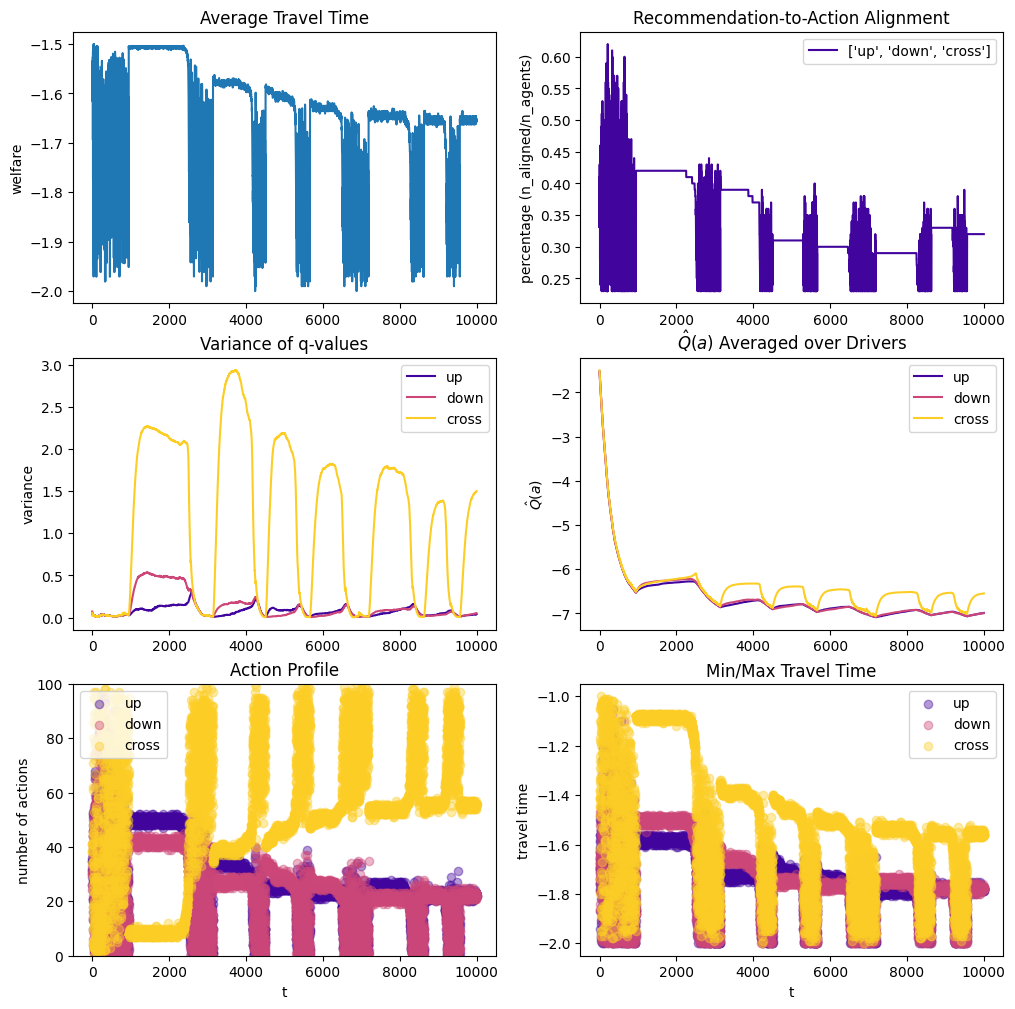

In [46]:
plot_run(M, "gamma9", N_AGENTS, N_ACTIONS, N_ITER)

gamma0


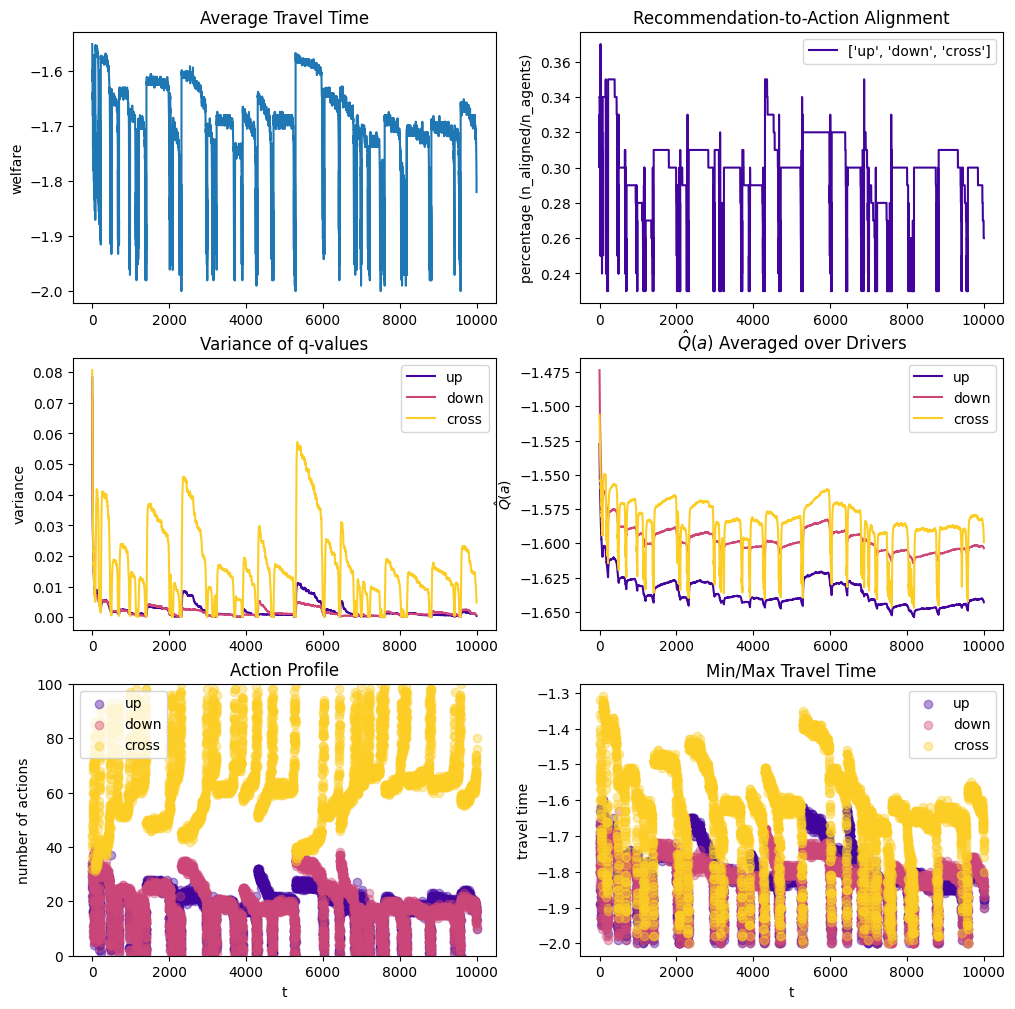

In [49]:
plot_run(M, "gamma0", N_AGENTS, N_ACTIONS, N_ITER)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


no_recommender


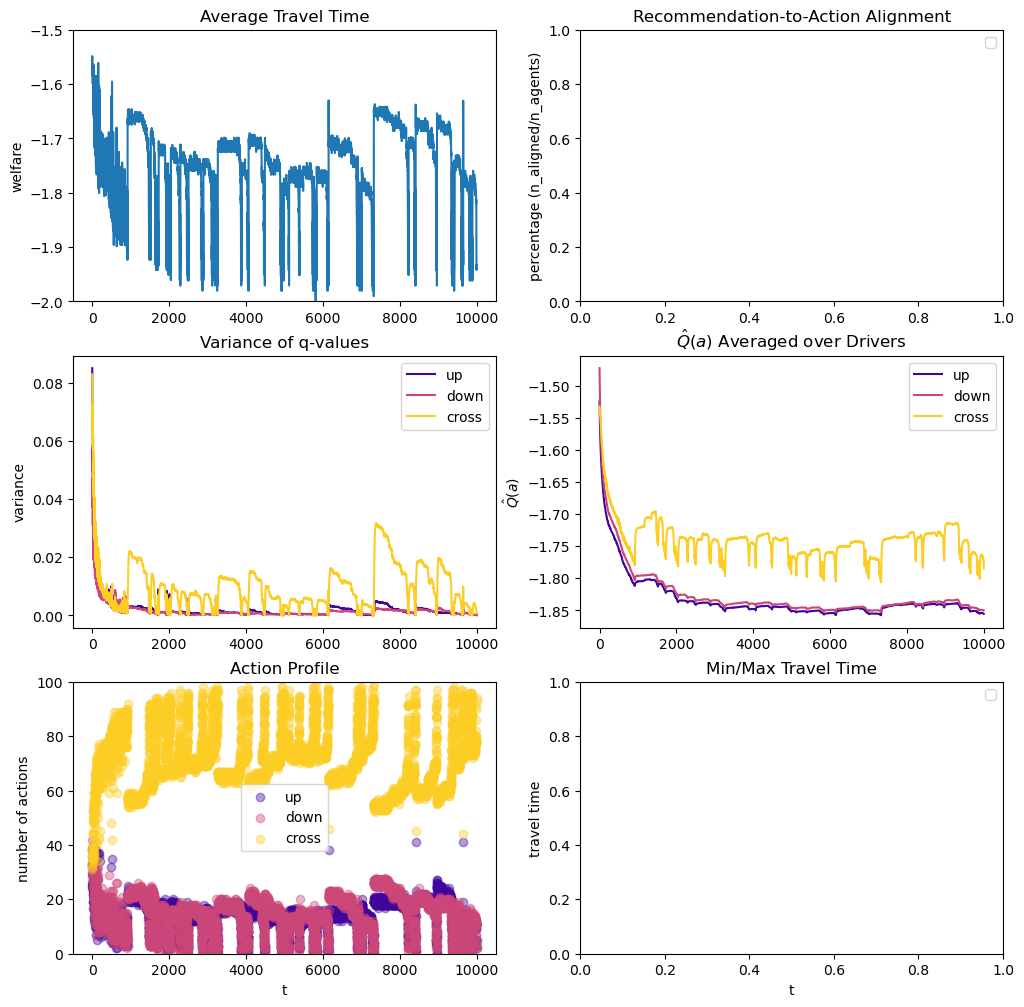

In [37]:
plot_run(M, "no_recommender", N_AGENTS, N_ACTIONS, N_ITER)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


optimized_heuristic_low_alpha


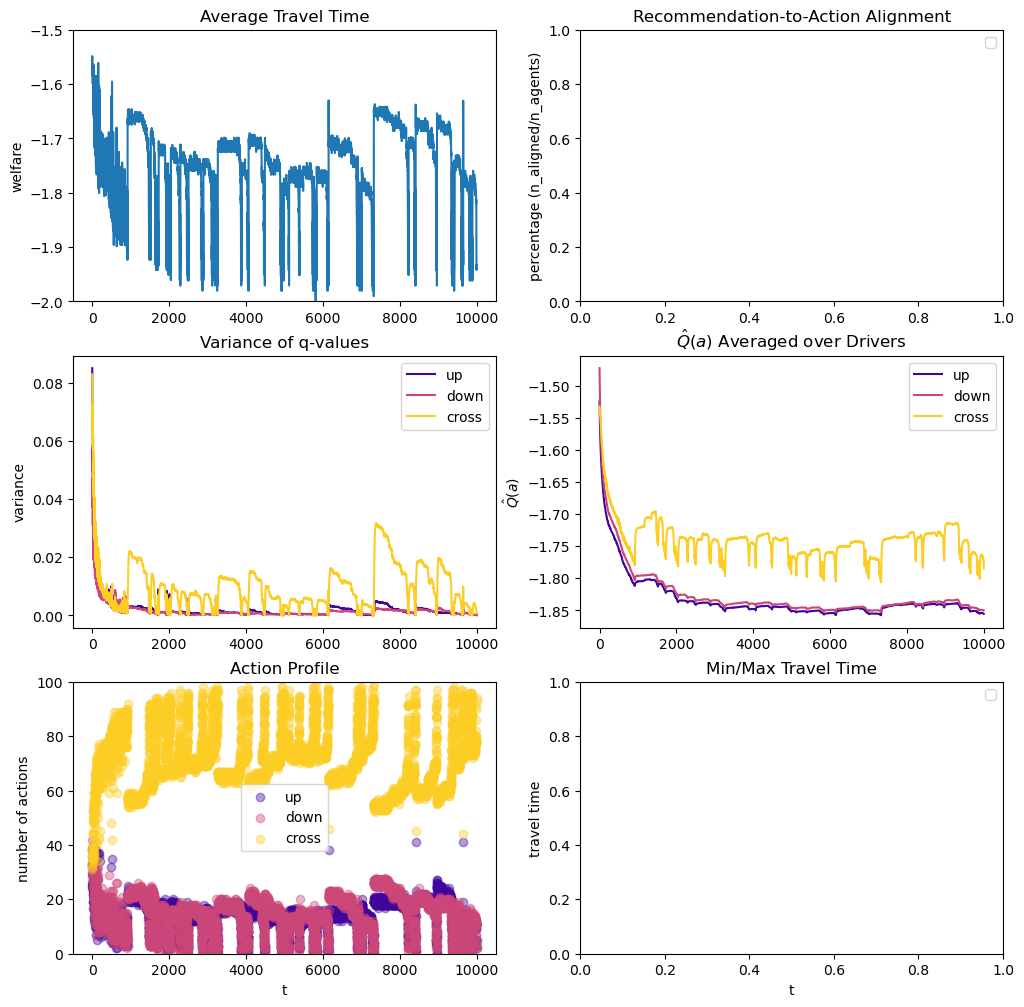

In [38]:
plot_run(M, "optimized_heuristic_low_alpha", N_AGENTS, N_ACTIONS, N_ITER)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


optimized_heuristic_low_alpha_action_maximize


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


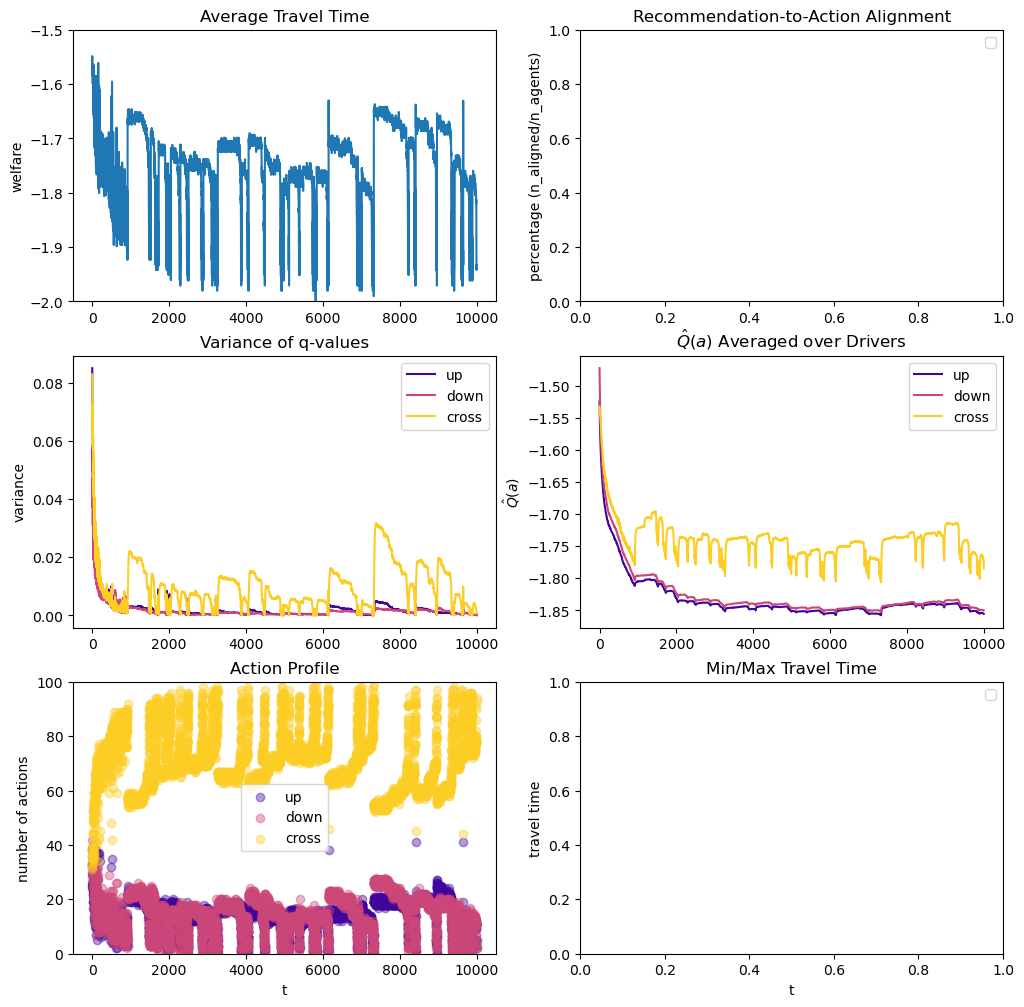

In [39]:
plot_run(M, "optimized_heuristic_low_alpha_action_maximize", N_AGENTS, N_ACTIONS, N_ITER)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


optimized_heuristic_low_alpha_action_minimize


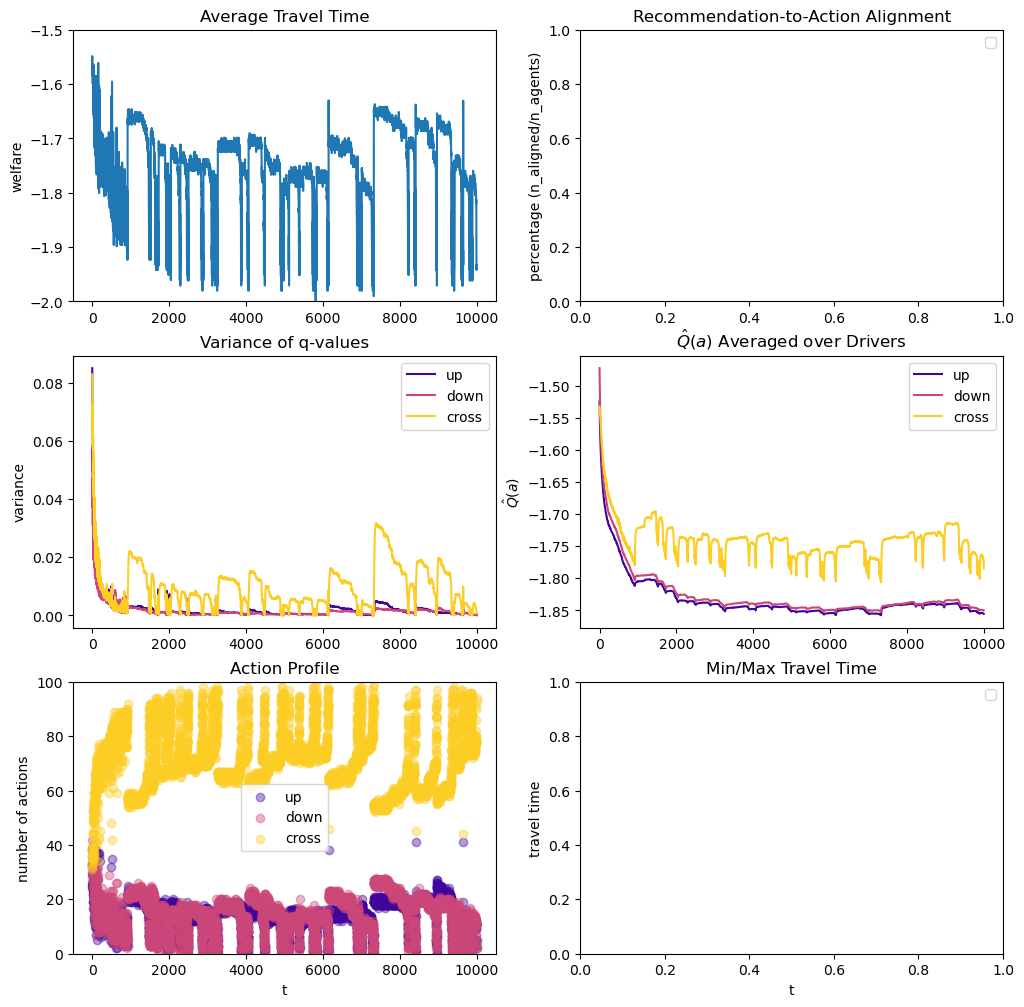

In [40]:
plot_run(M, "optimized_heuristic_low_alpha_action_minimize", N_AGENTS, N_ACTIONS, N_ITER)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


optimized_heuristic_low_alpha_estimate_maximize


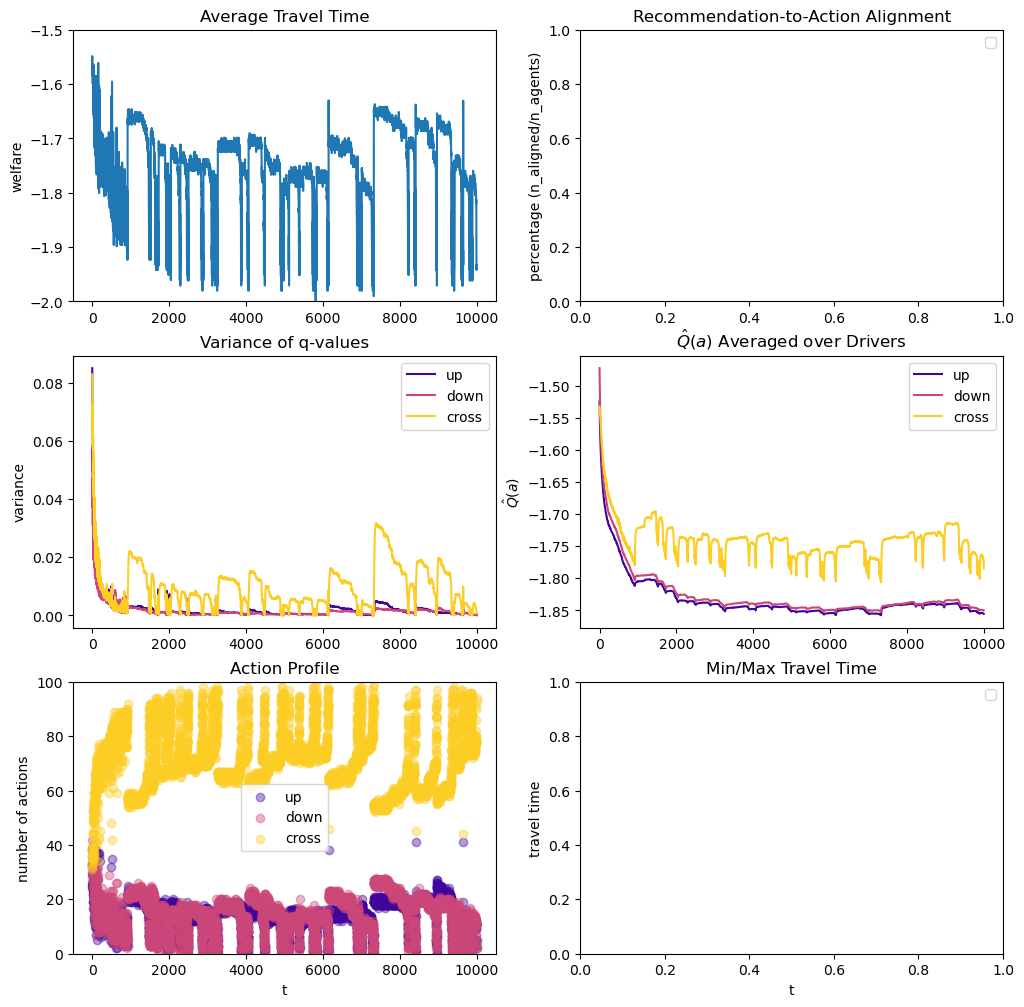

In [41]:
plot_run(M, "optimized_heuristic_low_alpha_estimate_maximize", N_AGENTS, N_ACTIONS, N_ITER)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


optimized_improvement_heuristic


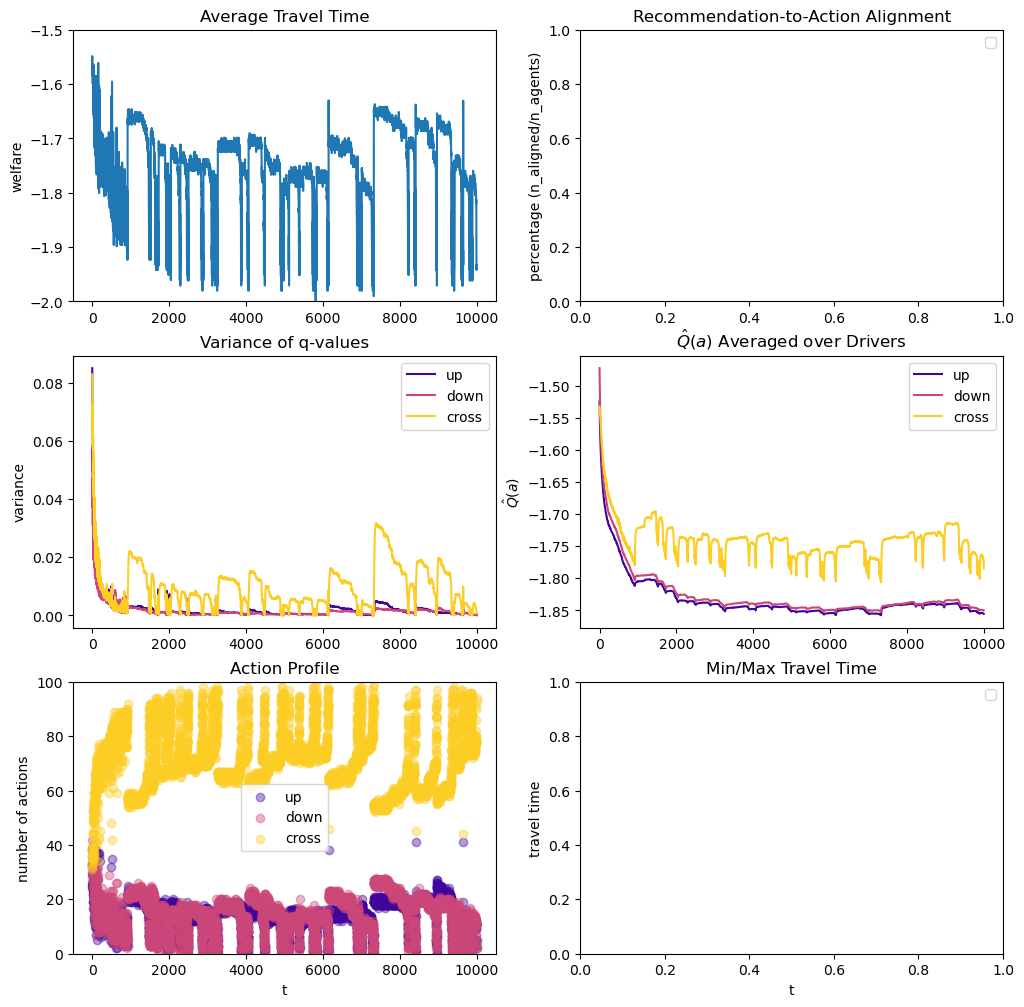

In [42]:
plot_run(M, "optimized_improvement_heuristic", N_AGENTS, N_ACTIONS, N_ITER)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


optimized_improvement_heuristic_low_alpha


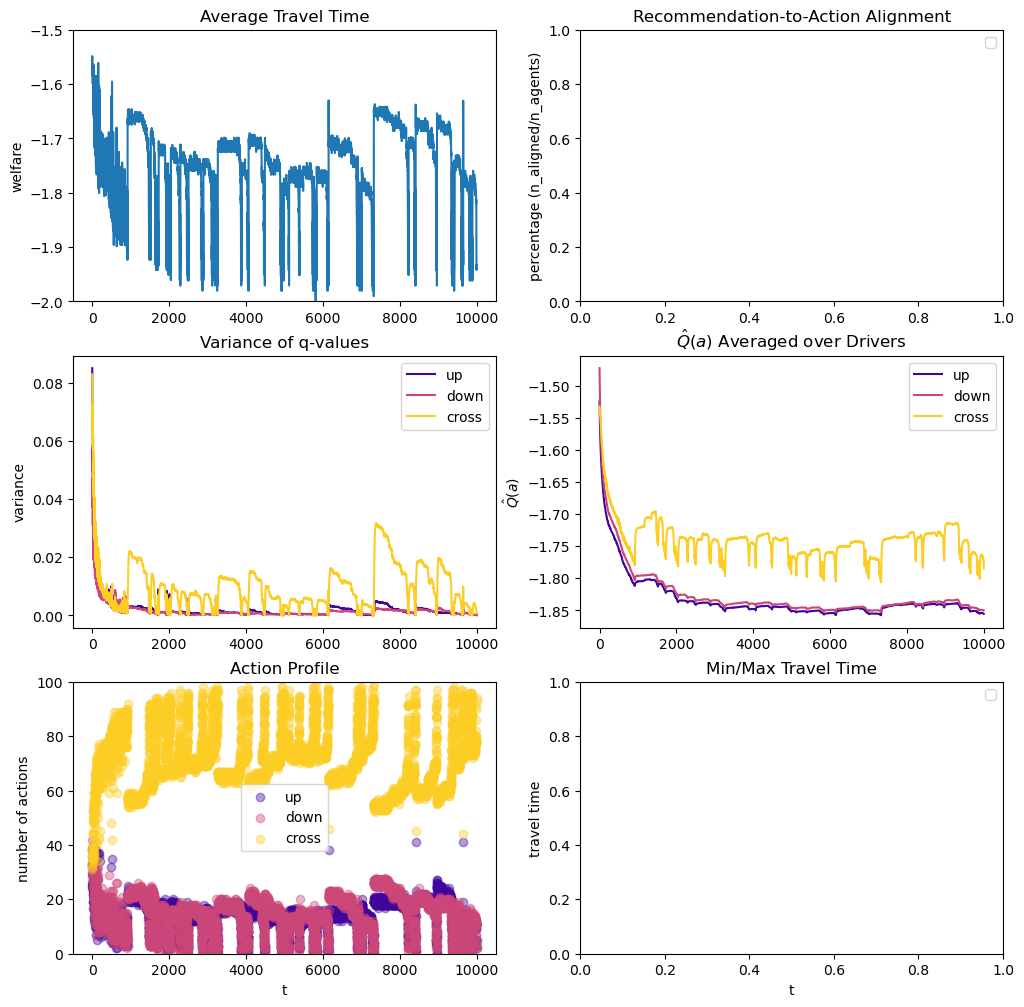

In [43]:
plot_run(M, "optimized_improvement_heuristic_low_alpha", N_AGENTS, N_ACTIONS, N_ITER)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


heuristic_low_alpha


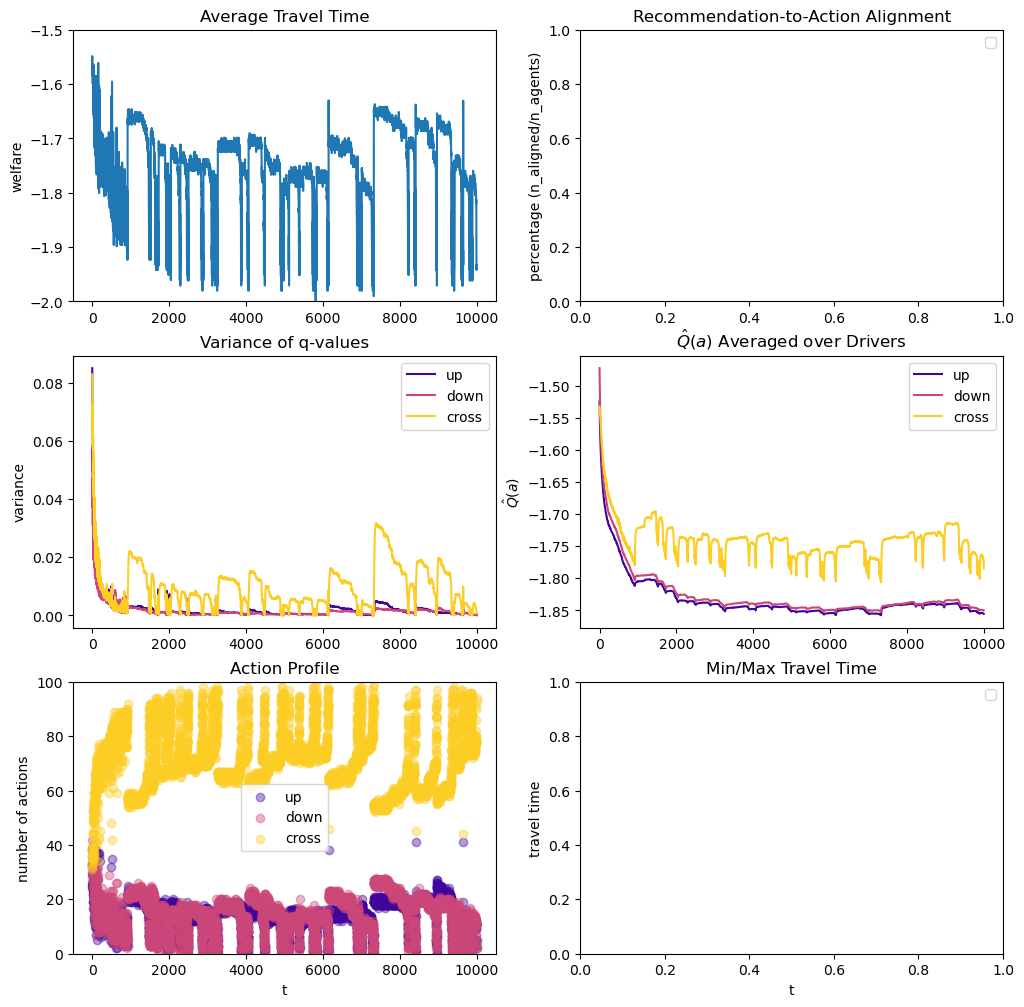

In [44]:
plot_run(M, "heuristic_low_alpha", N_AGENTS, N_ACTIONS, N_ITER)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


no_recommender_low_alpha


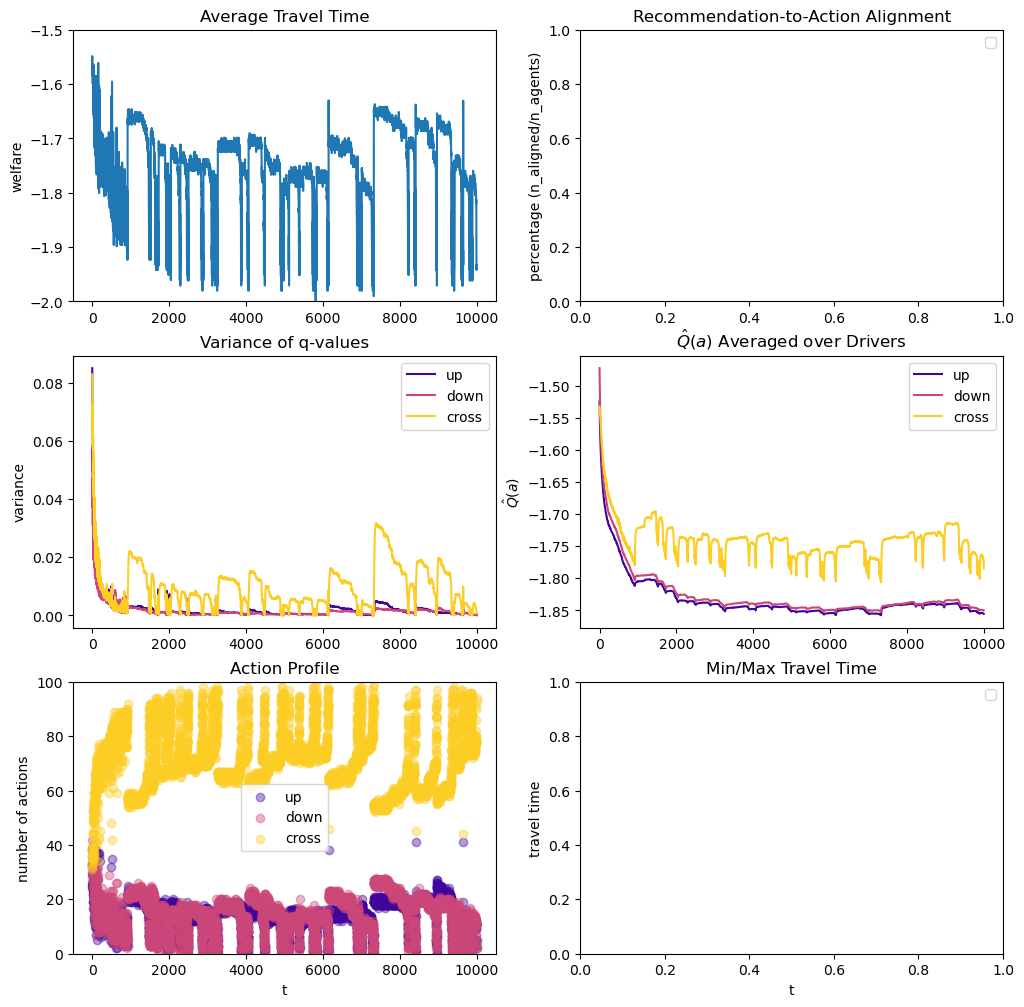

In [45]:
plot_run(M, "no_recommender_low_alpha", N_AGENTS, N_ACTIONS, N_ITER)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


aligned_low_alpha


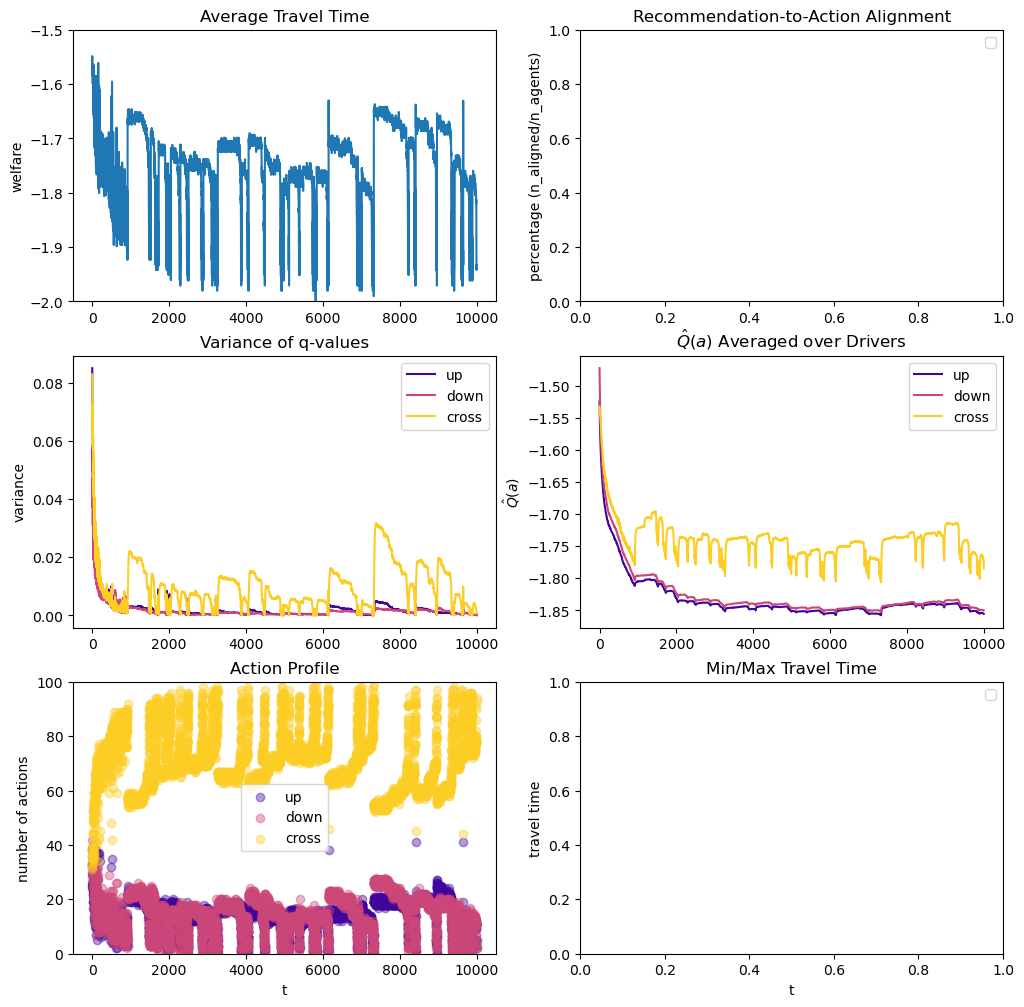

In [46]:
plot_run(M, "aligned_low_alpha", N_AGENTS, N_ACTIONS, N_ITER)

(0.0, 1.0)

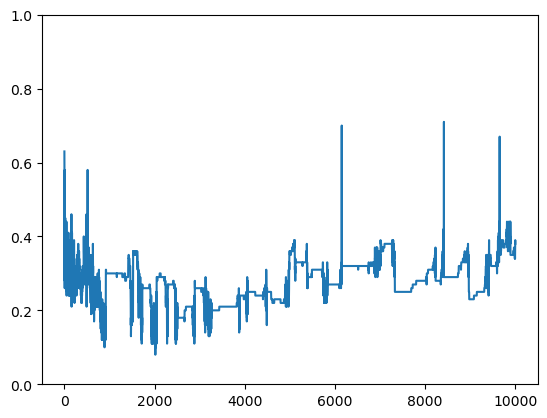

In [47]:
plt.plot([M[t]["recommendation_alignment"] for t in range(N_ITER)])
plt.ylim((0,1))

(0.0, 1.0)

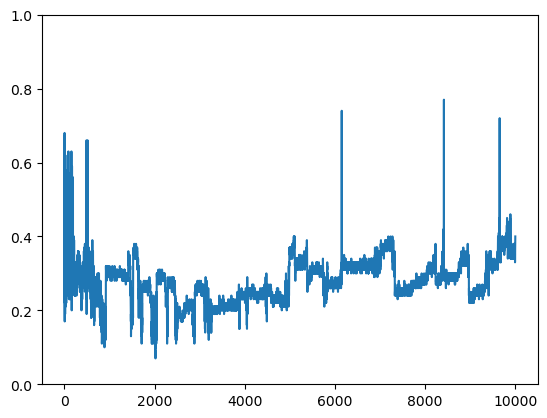

In [48]:
plt.plot([M[t]["action_alignment"] for t in range(N_ITER)])
plt.ylim((0,1))

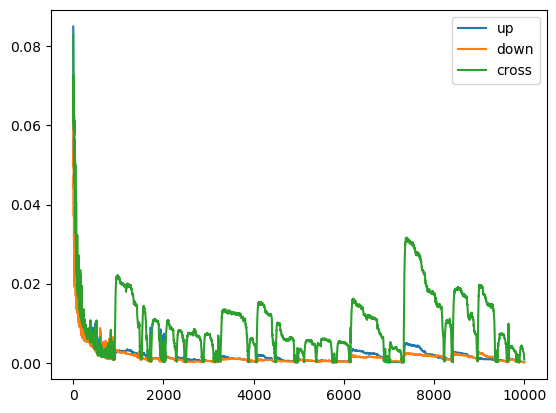

In [49]:
plt.plot([M[t]["Qvar"] for t in range(N_ITER)], label=["up", "down", "cross"])
plt.legend()

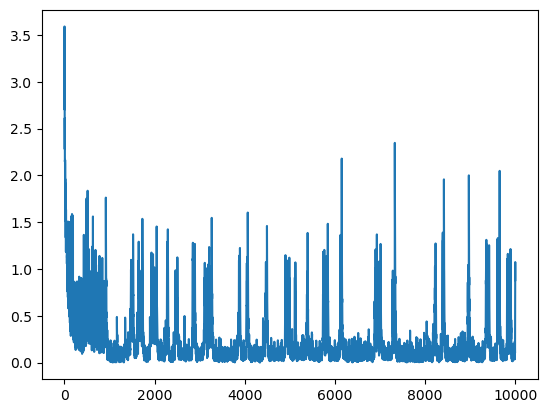

In [50]:
plt.plot([M[t]["sum_of_belief_updates"] for t in range(N_ITER)])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


optimized_heuristic_high_alpha_estimate_maximize


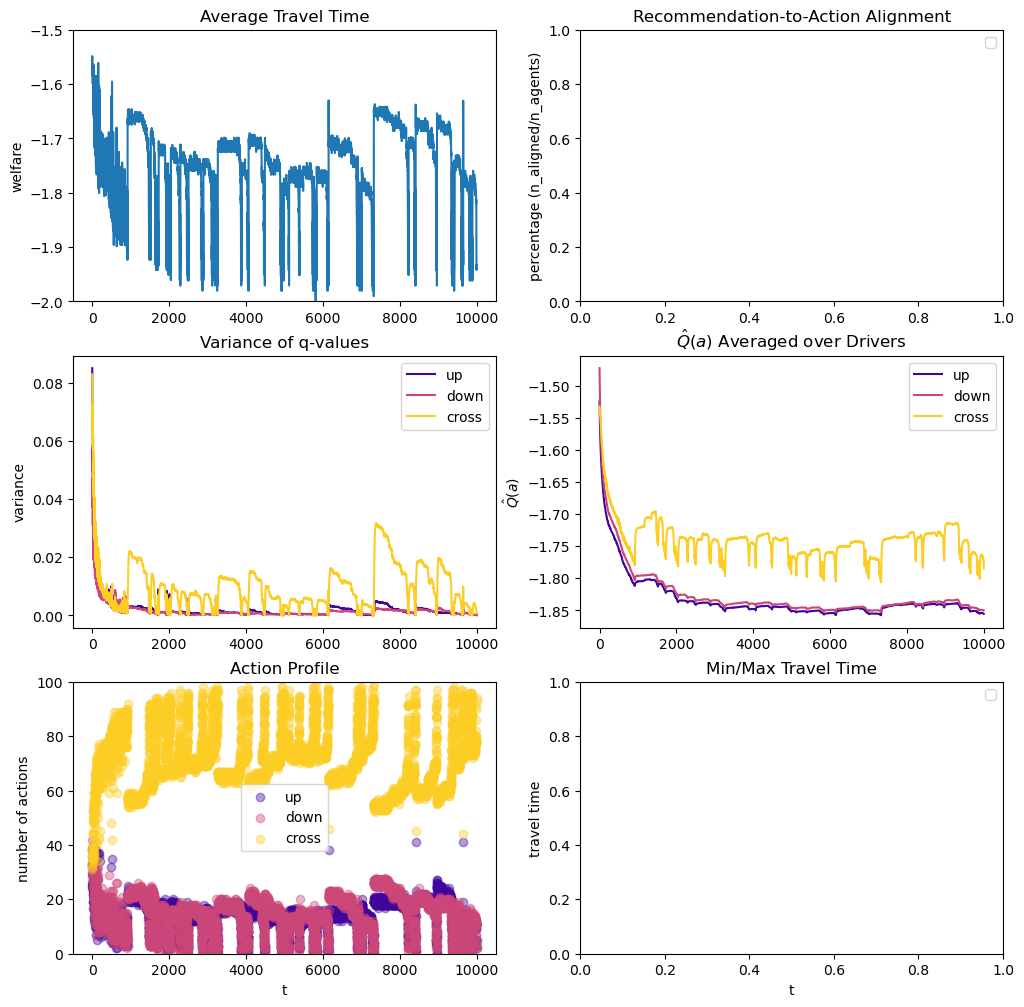

In [51]:
plot_run(M, "optimized_heuristic_high_alpha_estimate_maximize", N_AGENTS, N_ACTIONS, N_ITER)

## Two Route Game

In [5]:
def two_route_game(A):
    n_agents = len(A)
    n_up = (A == 0).sum()
    
    r_0 = n_up/n_agents
    r_1 = 1
    T = [-r_0, -r_1]

    R = np.array([T[i] for i in A])
    return R, T

In [6]:
from routing_networks import braess_initial_network

In [7]:
def braess_initial_network(A):
    n_agents = len(A)
    n_up = (A == 0).sum()
    n_down = (A == 1).sum()

    r_0 = 1 + n_up / n_agents
    r_1 = 1 + n_down / n_agents
    T = [-r_0, -r_1]

    R = np.array([T[a] for a in A])
    return R, T

In [8]:
def initial_braess_travel_time_estimate(n_up, n_agents):
    return [
        1 + n_up/n_agents,
        1 + (n_agents - n_up)/n_agents,
    ]

In [9]:
def two_route_recommender(Q, n_agents, method="estimate", minimize=False):
    S = np.zeros(n_agents)
    arg_max_Q = np.argmax(Q, axis=2)
    
    up, down, cross, flexible = split_up_down_cross_flexible(arg_max_Q)
    
    estimate = initial_braess_travel_time_estimate(len(up), n_agents)
    
    assign_flexible_to_up_down(S, up, down, flexible, Q, arg_max_Q, method, estimate, minimize)
    
    S = assign(S, Q, arg_max_Q, up, 0, method, estimate, minimize)
    S = assign(S, Q, arg_max_Q, down, 1, method, estimate, minimize)
#     S = assign_crossers(S, arg_max_Q, cross)
#     S = assign(S, Q, arg_max_Q, cross, 2, method, estimate, (not minimize))
    
    return S.astype(int)

In [28]:
N_AGENTS = 100
N_STATES = 2
N_ACTIONS = 2
N_ITER = 500

EPSILON = 0.2
mask = np.zeros(N_AGENTS)
mask[:] = 1
GAMMA = 0
ALPHA = 0.01

QINIT = np.array([-1.5, -1.5])
objective = total_welfare

/var/folders/11/3vmp2wls5_xb0s9pfn4zdp580000gq/T/ipykernel_47297/4217927544.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if EPSILON == "UNIFORM":


run_half_half


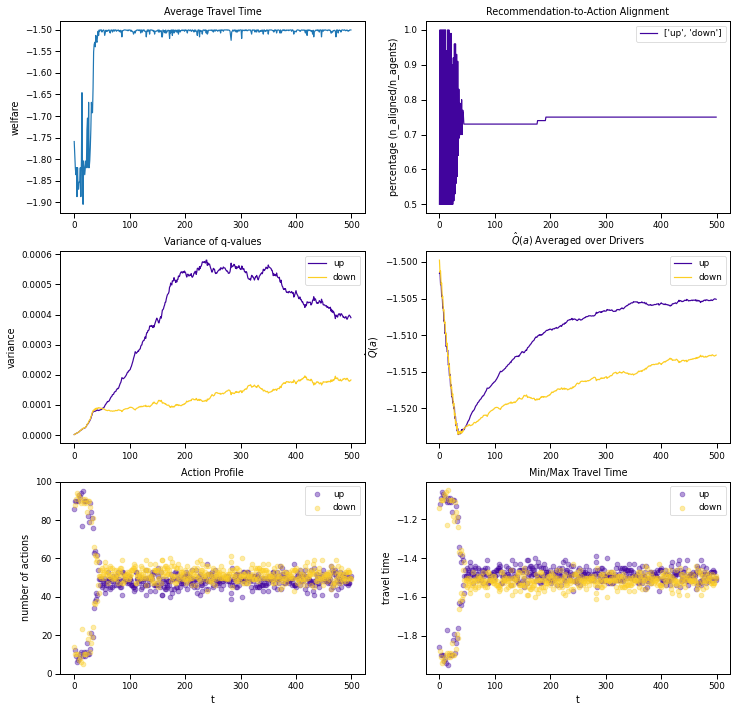

In [32]:
Q = initialize_q_table(QINIT, N_AGENTS, N_STATES, N_ACTIONS)

if ALPHA == "UNIFORM":
    ALPHA = np.random.random_sample(size=N_AGENTS)

if EPSILON == "UNIFORM":
    EPSILON = np.random.random_sample(size=N_AGENTS) * mask
else:
    EPSILON = EPSILON * np.ones(N_AGENTS) * mask

M = {}
ind = np.arange(N_AGENTS)
S = np.random.randint(N_STATES, size=N_AGENTS)
R = np.ones(N_AGENTS) * -2
A = np.random.randint(N_STATES, size=N_AGENTS)
# S = np.ones(N_AGENTS).astype(int)
# S = np.zeros(N_AGENTS).astype(int)
S = np.concatenate([np.zeros(int(N_AGENTS/2)).astype(int), np.ones(int(N_AGENTS/2)).astype(int)])

vectors = []

for t in range(N_ITER):
    
#     S = naive_recommender(Q, N_AGENTS)
#     S = heuristic_recommender(Q, N_AGENTS)
#     S = aligned_heuristic_recommender(Q, N_AGENTS)
#     S = optimized_heuristic_recommender(Q, N_AGENTS, method="estimate", minimize=True)
#     S = two_route_recommender(Q, N_AGENTS, method="estimate", minimize=False)
    
    A = e_greedy_select_action(Q, S, EPSILON)

    R, travel_time_per_route = braess_initial_network(A)

    Q, sum_of_belief_updates = bellman_update_q_table(Q, S, A, R, ALPHA, GAMMA)
    
    alignment, recommendation_alignment, action_alignment = calculate_alignment(Q, S, A)
    
    ## SAVE PROGRESS DATA
    M[t] = {"nA": np.bincount(A, minlength=3),
            "R": R,
            "Qmean": Q.mean(axis=1).mean(axis=0),
            "groups": count_groups(Q[ind, S, :], 0.1),
            "Qvar": Q[ind, S, :].var(axis=0),
            "nA": np.bincount(A, minlength=3),
            "T": travel_time_per_route,
            "sum_of_belief_updates": sum_of_belief_updates,
            "alignment": alignment,
            "recommendation_alignment": recommendation_alignment,
            "action_alignment": action_alignment,
           }
    
#     S = np.concatenate([np.zeros(int(N_AGENTS/2)).astype(int), np.ones(int(N_AGENTS/2)).astype(int)])
    
NAME = f"run_half_half"

plot_run(M, NAME, N_AGENTS, N_ACTIONS, N_ITER)

/var/folders/11/3vmp2wls5_xb0s9pfn4zdp580000gq/T/ipykernel_47297/4096508363.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if EPSILON == "UNIFORM":


run_misaligned_rec


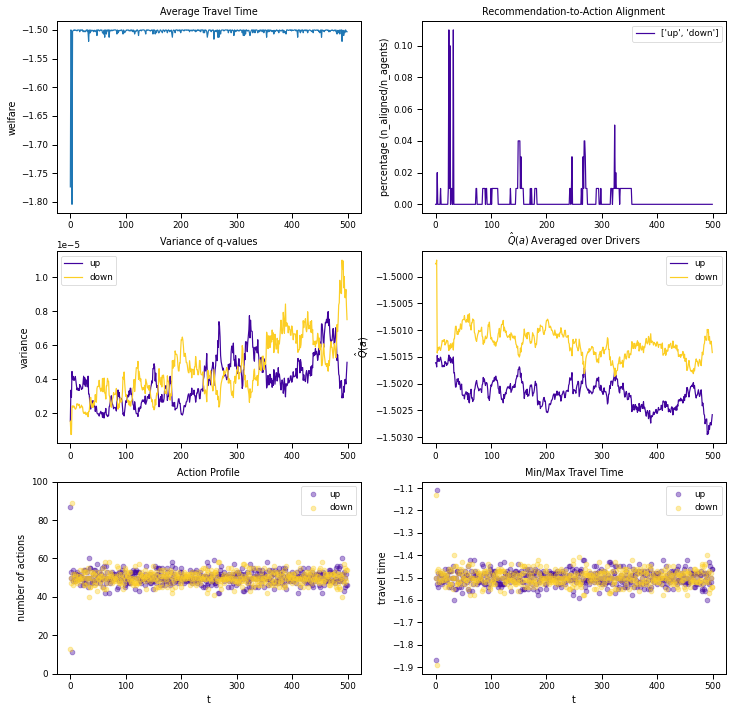

In [30]:
Q = initialize_q_table(QINIT, N_AGENTS, N_STATES, N_ACTIONS)

if ALPHA == "UNIFORM":
    ALPHA = np.random.random_sample(size=N_AGENTS)

if EPSILON == "UNIFORM":
    EPSILON = np.random.random_sample(size=N_AGENTS) * mask
else:
    EPSILON = EPSILON * np.ones(N_AGENTS) * mask

M2 = {}
ind = np.arange(N_AGENTS)
S = np.random.randint(N_STATES, size=N_AGENTS)
R = np.ones(N_AGENTS) * -2
A = np.random.randint(N_STATES, size=N_AGENTS)
# S = np.ones(N_AGENTS).astype(int)
S = np.zeros(N_AGENTS).astype(int)
# S = np.concatenate([np.zeros(int(N_AGENTS/2)).astype(int), np.ones(int(N_AGENTS/2)).astype(int)])

vectors = []

for t in range(N_ITER):
    
#     S = naive_recommender(Q, N_AGENTS)
#     S = heuristic_recommender(Q, N_AGENTS)
#     S = aligned_heuristic_recommender(Q, N_AGENTS)
#     S = optimized_heuristic_recommender(Q, N_AGENTS, method="estimate", minimize=True)
#     S = two_route_recommender(Q, N_AGENTS, method="estimate", minimize=False)
    
    A = e_greedy_select_action(Q, S, EPSILON)

    R, travel_time_per_route = braess_initial_network(A)

    Q, sum_of_belief_updates = bellman_update_q_table(Q, S, A, R, ALPHA, GAMMA)
    
    alignment, recommendation_alignment, action_alignment = calculate_alignment(Q, S, A)
    
    ## SAVE PROGRESS DATA
    M2[t] = {"nA": np.bincount(A, minlength=3),
            "R": R,
            "Qmean": Q.mean(axis=1).mean(axis=0),
            "groups": count_groups(Q[ind, S, :], 0.1),
            "Qvar": Q[ind, S, :].var(axis=0),
            "nA": np.bincount(A, minlength=3),
            "T": travel_time_per_route,
            "sum_of_belief_updates": sum_of_belief_updates,
            "alignment": alignment,
            "recommendation_alignment": recommendation_alignment,
            "action_alignment": action_alignment,
           }
    
    S = np.concatenate([np.zeros(int(N_AGENTS/2)).astype(int), np.ones(int(N_AGENTS/2)).astype(int)])
    
NAME = f"run_misaligned_rec"

plot_run(M2, NAME, N_AGENTS, N_ACTIONS, N_ITER)

/var/folders/11/3vmp2wls5_xb0s9pfn4zdp580000gq/T/ipykernel_47297/758715389.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if EPSILON == "UNIFORM":


run_aligned_rec


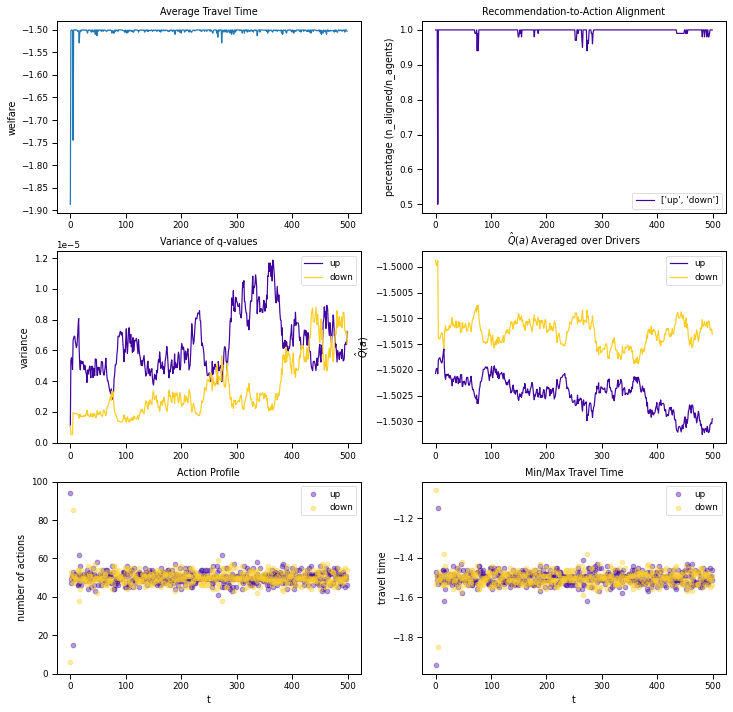

In [31]:
Q = initialize_q_table(QINIT, N_AGENTS, N_STATES, N_ACTIONS)

if ALPHA == "UNIFORM":
    ALPHA = np.random.random_sample(size=N_AGENTS)

if EPSILON == "UNIFORM":
    EPSILON = np.random.random_sample(size=N_AGENTS) * mask
else:
    EPSILON = EPSILON * np.ones(N_AGENTS) * mask

M3 = {}
ind = np.arange(N_AGENTS)
S = np.random.randint(N_STATES, size=N_AGENTS)
R = np.ones(N_AGENTS) * -2
A = np.random.randint(N_STATES, size=N_AGENTS)
S = np.ones(N_AGENTS).astype(int)
# S = np.zeros(N_AGENTS).astype(int)
# S = np.concatenate([np.zeros(int(N_AGENTS/2)).astype(int), np.ones(int(N_AGENTS/2)).astype(int)])

vectors = []

for t in range(N_ITER):
    
#     S = naive_recommender(Q, N_AGENTS)
#     S = heuristic_recommender(Q, N_AGENTS)
#     S = aligned_heuristic_recommender(Q, N_AGENTS)
#     S = optimized_heuristic_recommender(Q, N_AGENTS, method="estimate", minimize=True)
#     S = two_route_recommender(Q, N_AGENTS, method="estimate", minimize=False)
    
    A = e_greedy_select_action(Q, S, EPSILON)

    R, travel_time_per_route = braess_initial_network(A)

    Q, sum_of_belief_updates = bellman_update_q_table(Q, S, A, R, ALPHA, GAMMA)
    
    alignment, recommendation_alignment, action_alignment = calculate_alignment(Q, S, A)
    
    ## SAVE PROGRESS DATA
    M3[t] = {"nA": np.bincount(A, minlength=3),
            "R": R,
            "Qmean": Q.mean(axis=1).mean(axis=0),
            "groups": count_groups(Q[ind, S, :], 0.1),
            "Qvar": Q[ind, S, :].var(axis=0),
            "nA": np.bincount(A, minlength=3),
            "T": travel_time_per_route,
            "sum_of_belief_updates": sum_of_belief_updates,
            "alignment": alignment,
            "recommendation_alignment": recommendation_alignment,
            "action_alignment": action_alignment,
           }
    
    S = np.concatenate([np.zeros(int(N_AGENTS/2)).astype(int), np.ones(int(N_AGENTS/2)).astype(int)])
    
NAME = f"run_aligned_rec"

plot_run(M3, NAME, N_AGENTS, N_ACTIONS, N_ITER)

# Paper Figures

In [27]:
import seaborn as sns

import matplotlib.pylab as pylab
sns.set_context("paper")


plt.style.use('paper.mplstyle')

# colors = sns.color_palette(palette='pastel', n_colors=3)
colors = sns.color_palette(palette='Set2', n_colors=3)
M_data = [M, M2, M3]
labels = ['half-half', 'misaligned', 'aligned']
ls = ['-', '-.']

OSError: 'paper.mplstyle' not found in the style library and input is not a valid URL or path; see `style.available` for list of available styles

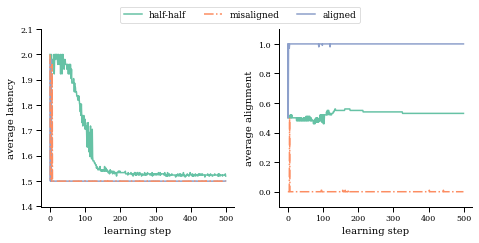

In [13]:
fig, [ax, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(6.75, 3.2))

handles = []

for i, (m, color, label) in enumerate(zip(M_data, colors, labels)):
    line, = ax.plot([-m[t]["R"].mean() for t in range(N_ITER)], color=color, 
            label=label, linestyle=ls[i%2], zorder=i%2)
    handles.append(line)

    ax2.plot([m[t]["recommendation_alignment"] for t in range(N_ITER)], color=color, 
         label=label, linestyle=ls[i%2], zorder=i%2)
    
    
ax.set_ylim((1.4, 2.1))
ax.set_xlabel('learning step')
ax.set_ylabel('average latency')

ax2.set_ylim((-0.1, 1.1))
ax2.set_xlabel('learning step')
ax2.set_ylabel('average alignment')
sns.despine()

fig.tight_layout()
fig.legend(bbox_to_anchor=(0.5,0.95), loc='lower center', ncol = 3, handles = handles)
plt.savefig("two_route_summary.pdf", bbox_inches='tight')
# plt.show()

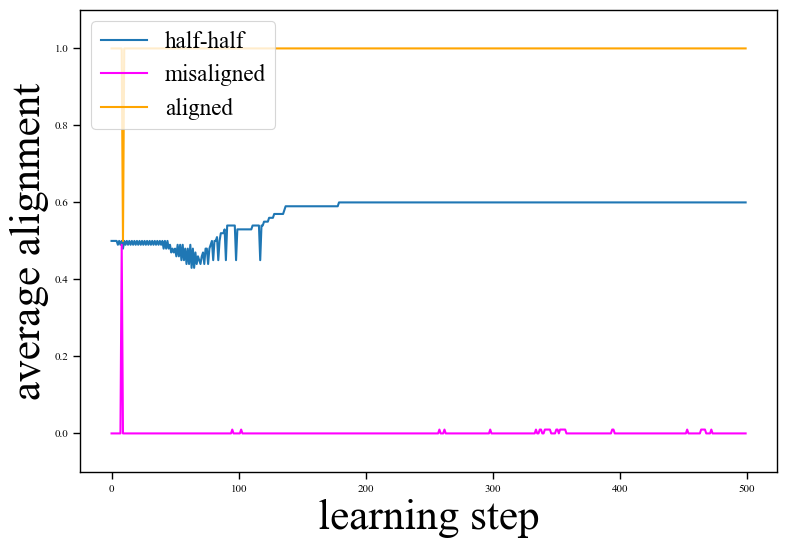

In [173]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))

ax.plot([M[t]["recommendation_alignment"] for t in range(N_ITER)], color=u'#1f77b4', label="half-half")
ax.plot([M2[t]["recommendation_alignment"] for t in range(N_ITER)], color='magenta', label="misaligned")
ax.plot([M3[t]["recommendation_alignment"] for t in range(N_ITER)], color='orange', label="aligned")
ax.set_ylim((-0.1, 1.1))
plt.xlabel('learning step', **{"fontname": "Times New Roman", "fontsize": "31"})
plt.ylabel('average alignment', **{"fontname": "Times New Roman", "fontsize": "31"})
plt.legend(fontsize="xx-large")
plt.savefig("two_route_alignment.pdf")
plt.show()

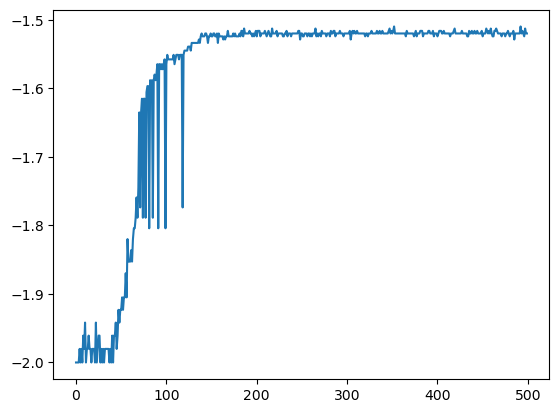

In [63]:
plt.plot([M[t]["R"].mean() for t in range(N_ITER)])

# Live Recommender Tool (needs sudo)

In [64]:
import keyboard

ModuleNotFoundError: No module named 'keyboard'

In [ ]:
N_AGENTS = 100
N_STATES = 3
N_ACTIONS = 3
N_ITER = 20000

EPSILON = 0.1
mask = np.zeros(N_AGENTS)
mask[:] = 1
GAMMA = 0
ALPHA = 0.25

QINIT = "UNIFORM"  # np.array([-2, -2, -2])

In [ ]:
Q = InitializeQTable(QINIT, N_AGENTS, N_STATES, N_ACTIONS)

if ALPHA == "UNIFORM":
    ALPHA = np.random.random_sample(size=N_AGENTS)

if EPSILON == "UNIFORM":
    EPSILON = np.random.random_sample(size=N_AGENTS) * mask
else:
    EPSILON = EPSILON * np.ones(N_AGENTS) * mask

M = {}

S = np.random.randint(N_STATES, size=N_AGENTS)
R = np.ones(N_AGENTS) * -2
A = np.random.randint(N_STATES, size=N_AGENTS)

In [ ]:
# %matplotlib widget

fig = plt.figure(figsize=(10,8))
hfig = display(fig, display_id=True)
recommender_on = False

on_timesteps = []
off_timesteps = []

for t in range(N_ITER):
    if keyboard.is_pressed("r"):
        recommender_on = True
        on_timesteps.append(t)
        S = heuristic_recommender(Q, N_AGENTS)
    elif keyboard.is_pressed("e"):
        recommender_on = False
        off_timesteps.append(t)
        S = S
    
#     S = recommender_next_state(R, Q, S, A, recommender_on)
    
    A = e_greedy_select_action(Q, S, EPSILON)

    R, _ = braess_augmented_network(A)

    Q, _ = bellman_update_q_table(Q, S, A, R, ALPHA, GAMMA)

    ## SAVE PROGRESS DATA
    M[t] = {"nA": np.bincount(A, minlength=3),
            "R": R,
            "Qmean": Q.mean(axis=1).mean(axis=0),
            # "groups": count_groups(Q[ind, S, :], 0.1),
            # "Qvar": Q[ind, S, :].var(axis=0)
           }
    
    plt.clf()
    plt.plot(np.arange(0, t, 1), [M[i]["R"].mean() for i in range(t)])
#     plt.plot(on_timesteps, [M[i]["R"].mean() for i in on_timesteps])
#     plt.plot(off_timesteps, [M[i]["R"].mean() for i in off_timesteps])
#     ax2.hist(np.bincount(S))
    fig.canvas.draw()
    hfig.update(fig)
    time.sleep(0.1)
    